# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](Need to update this).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 

## Pre-Reqs & Python Version
Notebook code has been executed with python 3.9.5

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [ ]:
# ensure that the correct lib are installed
!pip install -r requirements.txt

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [5]:
print(f'User-Article dataset shape: {df.shape}')

User-Article dataset shape: (45993, 3)


In [6]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [7]:
print(f'Content dataset shape: {df_content.shape}')


Content dataset shape: (1056, 5)


In [8]:
set_user_articles = set(df['article_id'])
set_conent_articles = set(df_content['article_id'])

print(f'{"Number of different articles in user-interactions df":70}: {len(set_user_articles):5d}')
print(f'{"Number of different articles in content df":70}: {len(set_conent_articles):5d}')
print(f'{"Number of user-interaction articles NOT in content df":70}: {len(set_user_articles - set_conent_articles):5d}')
print(f'{"Number of articles in content df and NOT in user-interaction":70}: {len(set_conent_articles-set_user_articles):5d}')
print(f'{"Number of articles in both content df AND user-interaction":70}: {len(set_conent_articles & set_user_articles):5d}')


Number of different articles in user-interactions df                  :   714
Number of different articles in content df                            :  1051
Number of user-interaction articles NOT in content df                 :   277
Number of articles in content df and NOT in user-interaction          :   614
Number of articles in both content df AND user-interaction            :   437


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

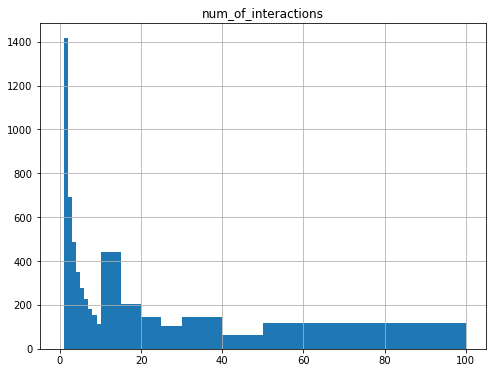

In [17]:
# group by email (=by user)
df_grpby_user = df.groupby('email')

# get number of interactions per user
df_grpby_user_interactions = df_grpby_user[['article_id']].count()
# rename the "count" columns
df_grpby_user_interactions.rename(columns={'article_id':'num_of_interactions'}, inplace=True)

# draw history diagram using defined bins
fig, axs = plt.subplots(figsize=(8, 6))
df_grpby_user_interactions.hist(bins=[0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50,100], ax=axs)
fig.savefig('img/hist_interactions.jpg')


In [18]:
#describe the groupby user interaction dataset
df_grpby_user_interactions.describe()

,num_of_interactions
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


In [19]:
# 50% of individuals interact with ____ number of articles or fewer.
median_val = 3 

# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = 364 

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [20]:
# Find and explore duplicate articles
print('Duplicate Articles')
print(df_content[df_content['article_id'].duplicated()][['article_id','doc_full_name']])

Duplicate Articles
     article_id                                      doc_full_name
365          50                       Graph-based machine learning
692         221  How smart catalogs can turn the big data flood...
761         398  Using Apache Spark as a parallel processing fr...
970         577                              Use the Primary Index
971         232  Self-service data preparation with IBM Data Re...


In [21]:
# Remove any rows that have the same article_id - only keep the first
df_content['article_id'].drop_duplicates(keep='first',inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values)<br> 
**d.** The number of user-article interactions in the dataset.

In [22]:
n_articles_with_interaction = df['article_id'].unique().shape[0]
print(f'{"num of articles with user interaction":40}: {n_articles_with_interaction:6}')

n_articles = df_content['article_id'].unique().shape[0]
print(f'{"num of articles":40}: {n_articles:6}')

n_users = df.groupby('email').ngroups
print(f'{"num of users":40}: {n_users:6}')

print(f'{"NULL Emails":40}: {df["email"].isnull().sum():6}')

n_user_interactions = df.shape[0]
print(f'{"num of users interactions":40}: {n_user_interactions:6}')

unique_articles = n_articles_with_interaction
total_articles = n_articles
unique_users = n_users
user_article_interactions = n_user_interactions


num of articles with user interaction   :    714
num of articles                         :   1051
num of users                            :   5148
NULL Emails                             :     17
num of users interactions               :  45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was find using other information that all of these null values likely belonged to a single user.

In [23]:
print('Count interactions per article')
df['article_id'].value_counts()

Count interactions per article


1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
         ... 
1119.0      1
417.0       1
724.0       1
653.0       1
1127.0      1
Name: article_id, Length: 714, dtype: int64

In [24]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = df['article_id'].value_counts().index[0] 

# The most viewed article in the dataset was viewed how many times?
max_views = df['article_id'].value_counts().iloc[0] 

print(f'Most viewed article: {most_viewed_article_id:5.0f}')
print(f'NUmber of views    : {max_views:5}')

Most viewed article:  1429
NUmber of views    :   937


In [25]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [26]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': str(most_viewed_article_id),
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

#### Functions Top-Articles

In [27]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here    
    top_articles = list(df.groupby(by='title').count().sort_values(by='user_id', ascending=False).head(n).index)
    return top_articles

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df['article_id'].value_counts().index[:n]
    return top_articles.tolist() # Return the top article ids

In [28]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [29]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

#### Functions user_item_matrix

In [30]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.drop_duplicates(['user_id','article_id'])    
    user_item = user_item.set_index(['user_id','article_id']).unstack()
    user_item.columns = [k[1] for k in user_item.columns.values]
    
    user_item[user_item.notnull()]=1
    user_item[user_item.isnull()]=0
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [31]:
print(f'User Item shape (#Users, #Articles): {user_item.shape}')

User Item shape (#Users, #Articles): (5149, 714)


In [32]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

#### Function find_similar_users

In [33]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    # sort by similarity
    similarity = user_item.dot(user_item.loc[user_id,:]).sort_values(ascending=False)
    
    # create a list of just ids and 
    # remove the own user's id
    most_similar_users = similarity.index
    most_similar_users = most_similar_users.drop(user_id).tolist()

    # return a list of the users in order from most to least similar
    return most_similar_users 
        

In [34]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

#### Function get_article_names

In [35]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''       
    # create a list of floats (can process str, int and floats)
    # as the article columns names are floats
    article_ids = [float(x) for x in article_ids]

    # get unique article names
    df_unique_titles = df[['article_id','title']].drop_duplicates()    

    article_names = df_unique_titles[df_unique_titles['article_id'].isin(article_ids)]['title']

    # Return the article names associated with list of article ids
    return article_names.tolist() 


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # get article IDs from user_item column names
    article_ids = user_item.columns[user_item.loc[user_id,:]==1].tolist()
    article_names = get_article_names(article_ids, df)

    # return the ids and names
    return article_ids, article_names 


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # find similar users
    most_similar_users  = find_similar_users(user_id)

    user_item_ids, _    = get_user_articles(user_id)
    set_user_item_ids   = set(user_item_ids)
    
    # temp sets
    recs_ids_set    = set()
    recs_names_set  = set()

    for loop_user_id in most_similar_users:
        if len(recs_ids_set) > m:
            break

        rec_id_list, _  = get_user_articles(loop_user_id)
        recs_ids_set    = recs_ids_set.union(set(rec_id_list) - set_user_item_ids)
    
    recs_names_set = get_article_names(list(recs_ids_set))

    return list(recs_ids_set)[:m]

In [36]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'fertility rate by country in total births per woman',
 'shaping data with ibm data refinery',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'data tidying in data science experience',
 'data science platforms are on the rise and ibm is leading the way',
 'from scikit-learn model to cloud with wml client',
 'from spark ml model to online scoring with scala']

In [37]:
# Check Results
user_user_recs(1, 10) # Return 10 recommendations for user 1

[1025.0, 2.0, 517.0, 1291.0, 524.0, 12.0, 14.0, 16.0, 1298.0, 1299.0]

In [38]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320.0, 232.0, 844.0])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [39]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    df_grpby_user = df.groupby('user_id')
    df_grpby_user_interactions = df_grpby_user[['article_id']].count()
    df_grpby_user_interactions.rename(columns={'article_id':'num_interactions'}, inplace=True)

    similarity = user_item.dot(user_item.loc[user_id,:]).sort_values(ascending=False)
    similarity.drop(user_id, inplace=True)
    df_similarity=pd.DataFrame(similarity,columns=['similarity'])

    neighbors_df = df_similarity.merge(df_grpby_user_interactions, on='user_id').sort_values(['similarity','num_interactions'], ascending=False)
    return neighbors_df # Return the dataframe specified in the doc_string

def get_user_article_ids(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user    
    
    Description:
    Provides a list of the article_ids that have been seen by a user
    '''
    # Your code here
    article_ids = user_item.columns[user_item.loc[user_id,:]==1].tolist()    

    return article_ids # return the ids and names

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    top_sorted_users = get_top_sorted_users(user_id)
    
    user_item_ids = get_user_article_ids(user_id)
    set_user_item_ids   = set(user_item_ids)
    #set_user_item_names = set(user_item_names)

    recs_ids_set    = set()
    recs_names_set  = set()

    for loop_user_id in top_sorted_users.index.tolist():
        if len(recs_ids_set) > m:
            break

        rec_id_list = get_user_article_ids(loop_user_id)

        recs_ids_set = recs_ids_set.union(set(rec_id_list) - set_user_item_ids)

    recs_names_set = get_article_names(recs_ids_set)

    return list(recs_ids_set)[:m], list(recs_names_set)[:m]

In [40]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1024.0, 12.0, 1296.0, 1304.0, 793.0, 555.0, 1324.0, 302.0, 1329.0, 1330.0]

The top 10 recommendations for user 20 are the following article names:
['ml optimization using cognitive assistant', 'deploy your python model as a restful api', 'apache spark lab, part 1: basic concepts', 'timeseries data analysis of iot events by using jupyter notebook', 'dsx: hybrid mode', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'ibm watson facebook posts for 2015', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'apache spark lab, part 3: machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [41]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[[0],:].index[0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[[9],:].index[0]# Find the 10th most similar user to user 131

print(user1_most_sim)
print(user131_10th_sim)

3933
242


In [42]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**
For a new user we can't use similarity because he hasn't read any articles so far and therefore there is no relation to any item (article) at all. For this reason we can use the rank based functions get_top_articles to recommend the most read articles.

A better alternative is to provide either some kind of filter that allows the user to specify some keywords or areas he is interested in (Content based filtering) and/or to let him rate some randomly selected items to use this information for collobarative filtering.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [43]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)
new_user_recs


[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0]

In [44]:
l = [float(k) for k in ['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']]
assert set(new_user_recs) == set(l), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [45]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [46]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [47]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')
#user_item_matrix = user_item

In [48]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perfrom SVD, and explain why this is different than in the lesson.

In [49]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix.to_numpy()) # use the built in to get the three matrices

**Provide your response here.**
The difference is that we have binary values (0,1) and no missing values. Therefore regular SVD can be used.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

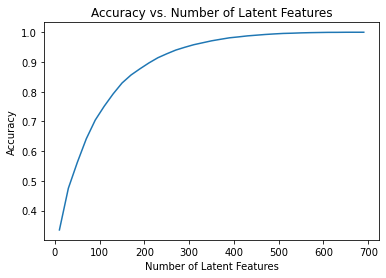

In [50]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [51]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test  = create_user_item_matrix(df_test)

    test_idx = user_item_test.index.tolist()
    test_arts= user_item_test.columns.tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [52]:
n_user_no_pred      = len(set(test_idx)- set(user_item_train.index.tolist()))
n_user_with_pred    = len(set(test_idx).intersection(set(user_item_train.index.tolist())))
n_articles_with_pred= len(set(test_arts).intersection(set(user_item_train.columns.tolist())) )
n_articles_no_pred  = len(set(test_arts) -set(user_item_train.columns.tolist()) )

print(f'user with no pred:              {n_user_no_pred:5}')
print(f'user with possible pred:        {n_user_with_pred:5}')
print(f'articles with no pred:          {n_articles_no_pred:5}')
print(f'articles with possible pred:    {n_articles_with_pred:5}')

user with no pred:                662
user with possible pred:           20
articles with no pred:              0
articles with possible pred:      574


In [53]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [54]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train.astype('float'),False) # fit svd similar to above then use the cells below

In [55]:
#
#   matrix that can be used for predictions ==> user and items are in both sets (test and train)
# 
predictable_user_train = user_item_train.index.isin(test_idx)
predictable_items_train= user_item_train.columns.isin(test_arts)

predictable_user_test = user_item_test.index.isin(user_item_train.index)

u_test = u_train[predictable_user_train, :]
vt_test = vt_train[:, predictable_items_train]

In [56]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []


for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_train_item_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_test_item_est = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    train_diffs = np.subtract(user_item_train, user_train_item_est)
    test_diffs = np.subtract(user_item_test.iloc[predictable_user_test,:], user_test_item_est)
    
    # total errors and keep track of them    
    train_err = np.sum(np.sum(np.abs(train_diffs)))
    sum_errs_train.append(train_err)

    test_err = np.sum(np.sum(np.abs(test_diffs)))
    sum_errs_test.append(test_err)

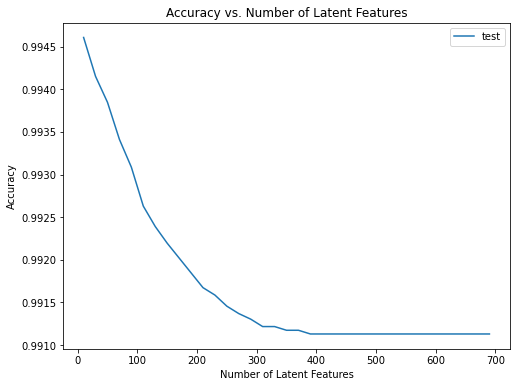

In [57]:
#
#   Plot accuracy test
#
fig, axs = plt.subplots(figsize=(8, 6))


plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df.shape[0], label='test');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend()

fig.savefig('img/accuracy_test.jpg')

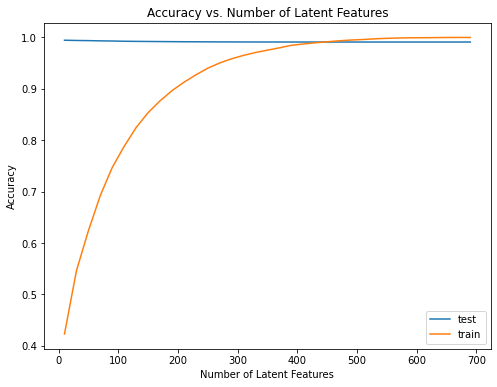

In [59]:
#
#   Plot accuracy - compare to train
#
fig, axs = plt.subplots(figsize=(8, 6))

plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df.shape[0], label='test');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/df.shape[0],label='train');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

fig.savefig('img/accuracy_traintest.jpg')

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**
#### Review of the results
The graphs show that increasing the latent feature will not give better results. The opposite is true so increasing latent features will increase the error on the test data set. One problem is that the intersection of users of the test and train data set is very small (20) to make a reliable test (test data set contains 682 users just 20 cann be used to test because just theses 20 are in the train set)

The collaborative filtering is very limited here as many users have just very few interactions (50%<=3>). In addition we  just rely on interactions without knowing if the user really like the article he interacted with. We could improve this by give the user the ability to rate an article (like / dislike, or 0..10 rating)

We could also use content based filtering so that user specifies areas or key words of interest and we use the knowledge of the article topics and content make recommendations.

#### Next Steps - Validate Recommendation Systems
**A/B Test** approach is a solid procedure to validate if the model brings real benefits in practice.

We could and should also use A/B testing to test how well our recommendation engine is working in practice and to validate our offline testing by a practice experiment. Therefore we will define and execute an AB-Test to answer the questions if the collaborative filtering sysem we developed will increase the average user interactions. 

We define Null and alternative Hypothesis and then split users randomly in two groups, a control and an experimental group, when they enter the homepage. 

The control group will get recommendations by old recommendation systen (no recommendation at all or recommendation by random  and so on) and the experimental group will get recommendations by new system ( collaborative filtered or by top_articles). 

If we have collected enough test data (defined by eperiment sizing) we then can calculate if the average user interactions of the experimental group is greater than the average interactions of the control group and if the calculated statistic is significant to a defined significance level alpha = 0.05 (or any other level based on the certainty we need for alpha or beta error ). 

If Null Hypothesis (user interactions of old system-control group- is equal or greate than user interactions of new system ) is rejected then we have a proof that the new recommendation system of the experimental group will improve the user interactions compared to the one used by the control group.


In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb', '--to', 'html'])

0